# CNN Baseline - iWildCam 2019

Breakdown of this notebook:
1. **Loading the 32x32 dataset**: Load the data generated in *Reducing Image Sizes to 32x32*.
2. **Create Callback for F1 Score**: F1-macro score is the official metric of the competition. We create a callback to keep track of that value as we train the model.
3. **Creating and Training the Model**: Create a simple model (taken from the official Keras tutorial) and train it.
4. **Evaluation**: Display the plots from the training history.
5. **Submission**: Run predictions with `model.predict`, and create submission csv file.

### References
* [cifar10_cnn_keras.py](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py): Heavily inspired from this tutorial created by the Keras team. The architecture and training process is directly taken from them.
* [Keras CNN Starter - PetFinder](https://www.kaggle.com/xhlulu/keras-cnn-starter-petfinder/): History plot and submission are inspired by this kernel
* [Reducing Image Sizes to 32x32](https://www.kaggle.com/xhlulu/reducing-image-sizes-to-32x32): Image data (`X_train`, `X_test`) come from the output of this kernel.
* [How to compute f1 score for each epoch in Keras](https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2): Needed to compute the F1 Score after each epoch.

In [2]:
import os
import json

import numpy as np
import pandas as pd
import keras
from keras.callbacks import Callback
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [3]:
os.listdir('./input')

['iwildcam-2019-fgvc6',
 'reducing-image-sizes-to-32x32',
 'test.csv',
 'test_images',
 'train.csv',
 'train_images']

## 1. Loading the 32x32 dataset

In [12]:
# The data, split between train and test sets:
x_train = np.load('./input/reducing-image-sizes-to-32x32/X_train.npy')
x_test = np.load('./input/reducing-image-sizes-to-32x32/X_test.npy')
y_train = np.load('./input/reducing-image-sizes-to-32x32/y_train.npy')

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (196299, 32, 32, 3)
196299 train samples
153730 test samples


In [13]:
# Convert the images to float and scale it to a range of 0 to 1
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

## 2. Create Callback for F1 score

In [6]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_pred = self.model.predict(X_val)

        y_pred_cat = keras.utils.to_categorical(
            y_pred.argmax(axis=1),
            num_classes=num_classes
        )

        _val_f1 = f1_score(y_val, y_pred_cat, average='macro')
        _val_recall = recall_score(y_val, y_pred_cat, average='macro')
        _val_precision = precision_score(y_val, y_pred_cat, average='macro')

        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)

        print((f"val_f1: {_val_f1:.4f}"
               f" — val_precision: {_val_precision:.4f}"
               f" — val_recall: {_val_recall:.4f}"))

        return

## 3. Creating and Training the Model

In [6]:
batch_size = 64
num_classes = 14
epochs = 30
val_split = 0.1
save_dir = os.path.join(os.getcwd(), 'models')
model_name = 'keras_cnn_model.h5'

In [7]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
f1_metrics = Metrics()

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

hist = model.fit(
    x_train, 
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[f1_metrics],
    validation_split=val_split,
    shuffle=True
)

Instructions for updating:
Use tf.cast instead.
Train on 176669 samples, validate on 19630 samples
Epoch 1/30
176669/176669 [==============================] - 481s 3ms/step - loss: 0.7102 - acc: 0.7807 - val_loss: 0.4834 - val_acc: 0.8427


C:\Users\kristela\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kristela\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val_f1: 0.5042 — val_precision: 0.5937 — val_recall: 0.4820
Epoch 2/30
176669/176669 [==============================] - 514s 3ms/step - loss: 0.5045 - acc: 0.8361 - val_loss: 0.4165 - val_acc: 0.8631
val_f1: 0.5777 — val_precision: 0.6643 — val_recall: 0.5513
Epoch 3/30
176669/176669 [==============================] - 519s 3ms/step - loss: 0.4467 - acc: 0.8543 - val_loss: 0.3639 - val_acc: 0.8805
val_f1: 0.6848 — val_precision: 0.7518 — val_recall: 0.6553
Epoch 4/30
176669/176669 [==============================] - 525s 3ms/step - loss: 0.4092 - acc: 0.8654 - val_loss: 0.3369 - val_acc: 0.8875
val_f1: 0.7268 — val_precision: 0.7725 — val_recall: 0.7049
Epoch 5/30
176669/176669 [==============================] - 484s 3ms/step - loss: 0.3829 - acc: 0.8724 - val_loss: 0.3278 - val_acc: 0.8924
val_f1: 0.7128 — val_precision: 0.7756 — val_recall: 0.6837
Epoch 6/30
176669/176669 [==============================] - 474s 3ms/step - loss: 0.3658 - acc: 0.8780 - val_loss: 0.3161 - val_acc: 0.8941


Save model and weights

In [10]:
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\kristela\Desktop\AY\DL\project\models\keras_cnn_model.h5 


## 4. Evaluation

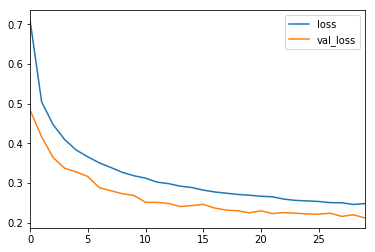

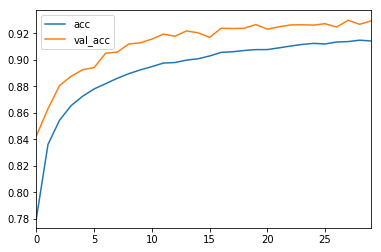

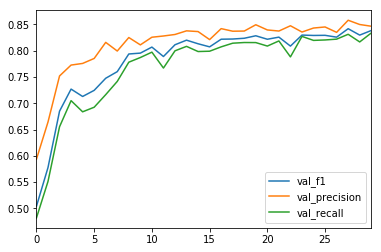

In [12]:
history_df = pd.DataFrame(hist.history)
history_df['val_f1'] = f1_metrics.val_f1s
history_df['val_precision'] = f1_metrics.val_precisions
history_df['val_recall'] = f1_metrics.val_recalls

history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()
history_df[['val_f1', 'val_precision', 'val_recall']].plot()

## 5. Submission

In [14]:
from tensorflow.keras.models import save_model, load_model
model_path = os.path.join(save_dir, model_name)
model = load_model(model_path)
print('Loaded trained model at %s ' % model_path)

Loaded trained model at C:\Users\kristela\Desktop\AY\DL\project\models\keras_cnn_model.h5 


In [ ]:
# Accuracy score for training data

In [20]:
y_pred = model.predict(x_train)

In [23]:
from sklearn.metrics import accuracy_score
y_train2 =  y_train.argmax(axis=1)
y_pred2 = y_pred.argmax(axis=1)
print(accuracy_score(y_train2, y_pred2))

0.9543196857854599


In [14]:
y_test = model.predict(x_test)

submission_df = pd.read_csv('./input/iwildcam-2019-fgvc6/sample_submission.csv')
submission_df['Predicted'] = y_test.argmax(axis=1)
print(submission_df.shape)
submission_df.head()

(153730, 2)


,Id,Predicted
0,b005e5b2-2c0b-11e9-bcad-06f10d5896c4,0
1,f2347cfe-2c11-11e9-bcad-06f10d5896c4,1
2,27cf8d26-2c0e-11e9-bcad-06f10d5896c4,0
3,f82f52c7-2c1d-11e9-bcad-06f10d5896c4,0
4,e133f50d-2c1c-11e9-bcad-06f10d5896c4,0


In [15]:
submission_df.to_csv('submission.csv',index=False)
history_df.to_csv('history.csv', index=False)

with open('history.json', 'w') as f:
    json.dump(hist.history, f)